In [59]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

asd_file = "asd.txt"
asd_columns=["freq","strain"]
gw_columns=["time", "h_plus", "h_cross", "h_H1", "h_L1"]

In [45]:
def read_file(filename,columns):
    # MAKE MORE EFFICIENTTTT
    file_dict={}
    f = open(filename,"r") 
    f_read=f.readlines()
    for line in f_read[1:]:
        split_line=line.split()
        for i in range(len(columns)):
            try:
                file_dict[columns[i]].append(float(split_line[i]))
            except:
                file_dict[columns[i]]=[float(split_line[i])]
                
    for i in range(len(columns)):
        file_dict[columns[i]]=np.array(file_dict[columns[i]])
    return file_dict


In [46]:
# reads in the asd and waveform files
GW150914_median_data=read_file("waveforms/GW150914_median.txt",gw_columns)
#GW150914_aligned_data=read_file("waveforms/GW151226_aligned.txt",gw_columns)
#LVT151012_aligned_data=read_file("waveforms/LVT151012_aligned.txt",gw_columns)

# asd file isn't the same length as the waveform templates; interpolate


wave_event_data=GW150914_median_data
#wave_event_data=GW150914_aligned_data
#wave_event_data=LVT151012_aligned_data

In [47]:
# modified slightly from the ligo code

#complex is easier to deal with
waveform = wave_event_data["h_plus"]+1.j*wave_event_data["h_cross"]
dt = wave_event_data["time"][1]-wave_event_data["time"][0]
fs = 4096 

# compute the instantaneous frequency of this chirp-like signal:
tphase = np.absolute(np.unwrap(np.angle(waveform)))

fGW = np.gradient(tphase)*fs/(2.*np.pi)
# fix discontinuities at the very end:
iffix = np.where(np.absolute(waveform) < np.absolute(waveform).max()*0.001)[0]
fGW[iffix] = fGW[iffix[0]-1]
fGW[np.where(fGW < 1.)] = fGW[iffix[0]-1]

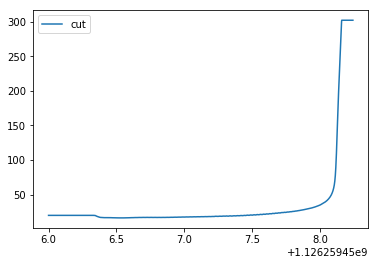

In [48]:
from statsmodels.nonparametric.smoothers_lowess import lowess


i_c=np.where(fGW==max(fGW))[0][0]

fGW_smooth = lowess(fGW[:i_c], wave_event_data["time"][:i_c], is_sorted=True, frac=0.025, it=0)[:,1]
fGW_smooth = np.lib.pad(fGW_smooth, (0,wave_event_data["time"].size-i_c), 'edge')

plt.figure()
#plt.plot(wave_event_data["time"],fGW,label="orig")
plt.plot(wave_event_data["time"],fGW_smooth,label="cut")
#plt.xlim(7.5+1.12625945e9, 8.3+1.12625945e9)
plt.legend(loc = 'upper left')
plt.show()

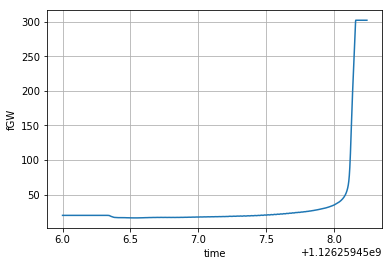

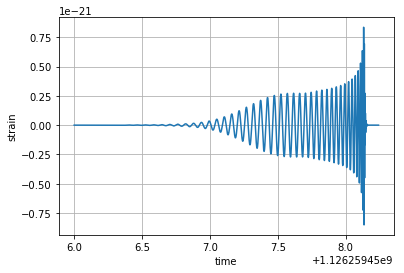

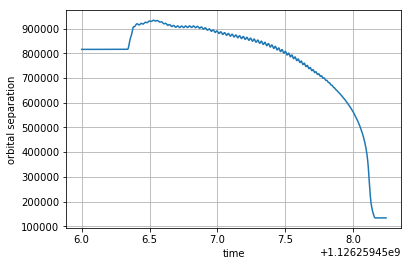

In [49]:
clight = 2.99792458e8                # m/s
G = 6.67259e-11                      # m^3/kg/s^2 
MSol = 1.989e30                      # kg
M_tot = 65.                           #  in solar masses; choose based on the template event

# calculating orbital separation
r = (G*M_tot*MSol/(4*(np.pi**2)*fGW_smooth_2**2))**(1./3)


time = wave_event_data["time"]


plt.figure()
plt.plot(time,fGW_smooth)
plt.grid()
plt.xlabel('time')
plt.ylabel('fGW')
#plt.xlim(7.0+1.12625945e9, 8.5+1.12625945e9)
plt.show()

plt.figure()
plt.plot(time,wave_event_data["h_L1"])
plt.grid()
plt.xlabel('time')
plt.ylabel('strain')
#plt.xlim(7.0+1.12625945e9, 8.5+1.12625945e9)
plt.show()

plt.figure()
plt.plot(time,r)
plt.grid()
plt.xlabel('time')
plt.ylabel('orbital separation')
#plt.xlim(7.0+1.12625945e9, 8.5+1.12625945e9)
plt.show()





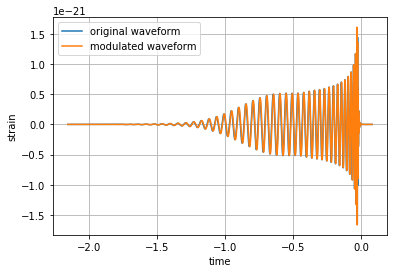

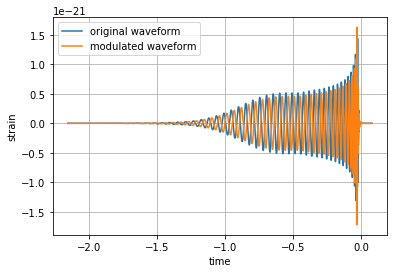

In [50]:
# now onto the lambda factor 

exp_arg = (G*M_tot*MSol)/(r*clight**2)

t_c=wave_event_data["time"][np.where(fGW==max(fGW))[0][0]]
shifted_time=time-t_c

waveform = wave_event_data["h_plus"]+1.j*wave_event_data["h_cross"]


def apply_modulation(waveform,lamda_amp,lamda_freq):
    waveform_fft = np.fft.fft(waveform)
    mult_factor=np.exp((lamda_amp+1.j*lamda_freq)*
    mult_factor=np.exp(1.j*lamda_freq*)
    mod_waveform_fft=waveform_fft*mult_factor
    mod_waveform=np.fft.ifft(mod_waveform_fft)
    return mod_waveform



plt.figure()
plt.plot(shifted_time,waveform,label="original waveform")
plt.plot(shifted_time,apply_modulation(waveform,1.,.5),label="modulated waveform")
plt.grid()
plt.xlabel('time')
plt.ylabel('strain')
plt.legend(loc='upper left')
plt.show()


plt.figure()
plt.plot(shifted_time,waveform,label="original waveform")
plt.plot(shifted_time,apply_modulation(waveform,1.,3.5),label="modulated waveform")
plt.grid()
plt.xlabel('time')
plt.ylabel('strain')
plt.legend(loc='upper left')
plt.show()

-1.0380859375 151.054794481


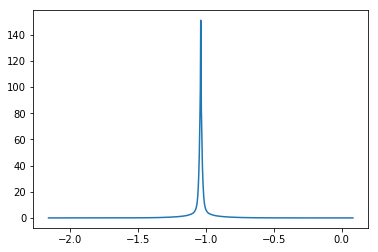

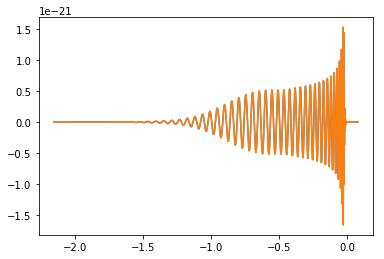

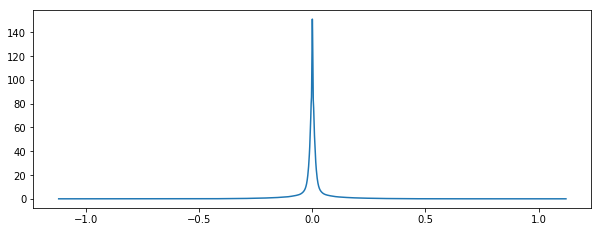

-1.03833007812 150.721253479


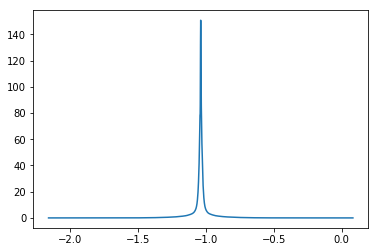

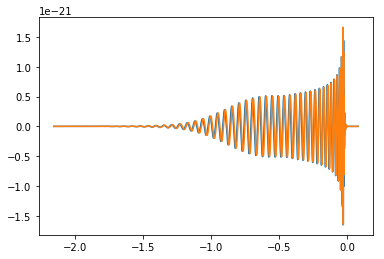

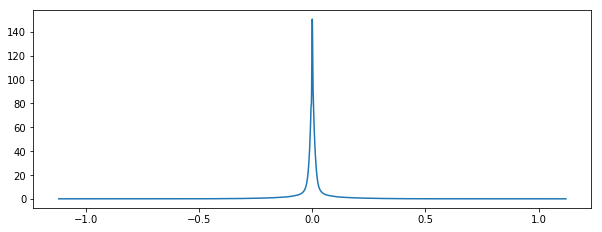

-1.03857421875 149.600800781


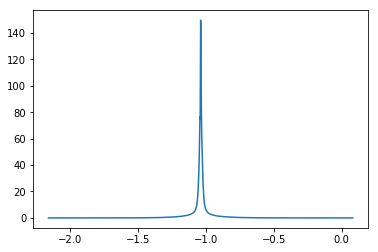

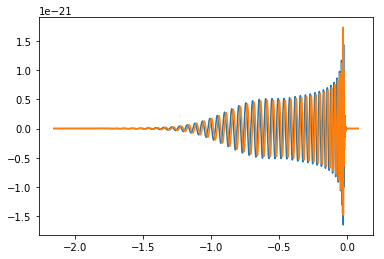

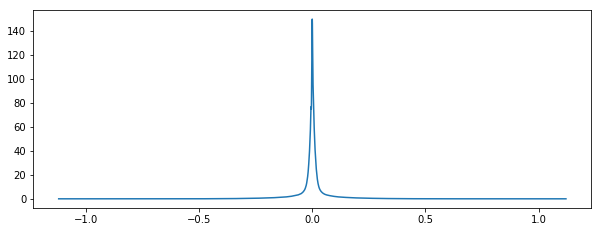

-1.03881835938 147.961413118


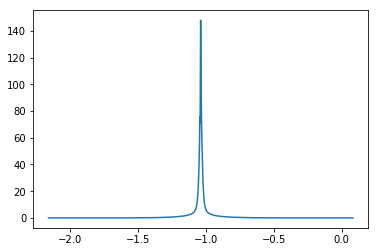

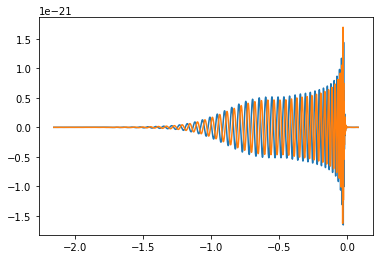

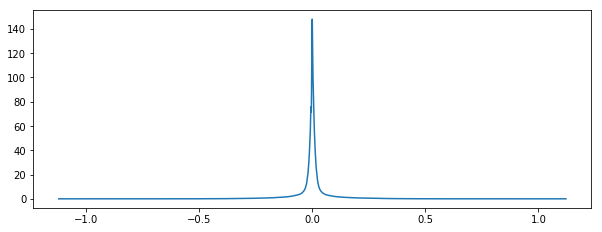

In [80]:
from scipy import signal
import matplotlib.mlab as mlab
# -- To calculate the PSD of the data, choose an overlap and a window (common to all detectors)
#   that minimizes "spectral leakage" https://en.wikipedia.org/wiki/Spectral_leakage
NFFT = 4*fs
psd_window = np.blackman(NFFT)
# and a 50% overlap:
NOVL = NFFT/2

# complex waveform template
template = wave_event_data["h_plus"]+1.j*wave_event_data["h_cross"]
# We will record the time where the data match the END of the template.

# the length and sampling rate of the template MUST match that of the data.
datafreq = np.fft.fftfreq(template.size)*fs
df = np.abs(datafreq[1] - datafreq[0])

# to remove effects at the beginning and end of the data stretch, window the data
# https://en.wikipedia.org/wiki/Window_function#Tukey_window
try:   dwindow = signal.tukey(template.size, alpha=1./8)  # Tukey window preferred, but requires recent scipy version 
except: dwindow = signal.blackman(template.size)          # Blackman window OK if Tukey is not available

    
# prepare the template fft.
template_fft = np.fft.fft(template*dwindow) / fs

 # -- Calculate the PSD of the data.  Also use an overlap, and window:
#asd = np.sqrt((1.e-22*(18./(0.1+datafreq))**2)**2+0.7e-23**2+((datafreq/2000.)*4.e-23)**2)
asd_data=read_file(asd_file,asd_columns)
dfreq=asd_data["freq"][1]-asd_data["freq"][0]
first_freqs=np.arange(asd_data["freq"][0],-dfreq,-dfreq)[::-1]
full_freqs=np.append(first_freqs,asd_data["freq"])
full_strain = np.pad(asd_data["strain"],(first_freqs.size,0),'constant', constant_values=(10.e-10, 0))
asd_func = interpolate.interp1d(full_freqs, full_strain)
data_psd = (asd_func(np.abs(datafreq))**2)
    


# loop over the diff lambda vals
lamdas = [0.,1.,2.,3.]
for lamda in lamdas:


   
    # Take the Fourier Transform (FFT) of the data and the template (with dwindow)
    data_fft = np.fft.fft(apply_modulation(waveform,1.,lamda)*dwindow) / fs
    
    # -- Interpolate to get the PSD values at the needed frequencies
    #power_vec = np.interp(np.abs(datafreq), freqs, data_psd)

    # -- Calculate the matched filter output in the time domain:
    # Multiply the Fourier Space template and data, and divide by the noise power in each frequency bin.
    # Taking the Inverse Fourier Transform (IFFT) of the filter output puts it back in the time domain,
    # so the result will be plotted as a function of time off-set between the template and the data:
    optimal = data_fft * template_fft.conjugate() / data_psd
    optimal_time = 2*np.fft.ifft(optimal)*fs

    # -- Normalize the matched filter output:
    # Normalize the matched filter output so that we expect a value of 1 at times of just noise.
    # Then, the peak of the matched filter output will tell us the signal-to-noise ratio (SNR) of the signal.
    sigmasq = 1*(template_fft * template_fft.conjugate() / data_psd).sum() * df
    sigma = np.sqrt(np.abs(sigmasq))
    SNR_complex = optimal_time/sigma

    # shift the SNR vector by the template length so that the peak is at the END of the template
    peaksample = int(data.size / 2)  # location of peak in the template
    
    SNR_complex = np.roll(SNR_complex,peaksample)
    SNR = abs(SNR_complex)
    
    # find the time and SNR value at maximum:
    indmax = np.argmax(SNR)
    timemax = shifted_time[indmax]
    SNRmax = SNR[indmax]
    
    print timemax,SNRmax

    plt.figure()
    plt.plot(shifted_time,SNR)
    plt.show()
    
    plt.figure()
    plt.plot(shifted_time,template)
    plt.plot(shifted_time,apply_modulation(waveform,1.,lamda))
    plt.show()
    
    plt.figure(figsize=(10,8))
    plt.subplot(2,1,1)
    plt.plot(shifted_time-timemax, SNR)
    plt.show()

    # Extract time offset and phase at peak
    phase = np.angle(SNR_complex[indmax])
    offset = (indmax-peaksample)
    #print offset
